In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [76]:
df = pd.read_hdf('./data/data2.hdf5')
df.reset_index(drop=True, inplace=True)

#### taking each bond length to be a descriptor & taking each entry in coulomb matrix to be a descriptor

In [165]:
bond_mat = np.zeros((len(df), 8))
for i in range(len(df)):
    x = df['Bonds'][i]
    for j in range(len(x)):
        bond_mat[i][j] = x[j][0]

In [195]:
coulomb_mat = np.zeros((len(df), 45))
for i in range(len(df)):
    x = df['Coulomb'][i]
    x = x.reshape(81,1)
    x = x[x > 0]
    for j in range(45):
        if np.isinf(x[j]):
            x[j] = 0
        coulomb_mat[i][j] = x[j]

In [196]:
coulomb_mat[50]

array([5.41937214e+03, 2.86376732e+08, 2.86376732e+08, 2.00615635e+05,
       2.00615635e+05, 2.00566975e+05, 2.00566975e+05, 2.00528918e+05,
       2.00528918e+05, 5.41937214e+03, 0.00000000e+00, 2.00756271e+05,
       2.00756271e+05, 2.00707542e+05, 2.00707542e+05, 2.00669432e+05,
       2.00669432e+05, 5.41937214e+03, 2.00756271e+05, 2.00756271e+05,
       2.00707542e+05, 2.00707542e+05, 2.00669432e+05, 2.00669432e+05,
       5.41937214e+03, 1.72938226e+18, 8.26896211e+08, 8.26896211e+08,
       4.63916590e+08, 4.63916590e+08, 5.41937214e+03, 8.26896212e+08,
       8.26896211e+08, 4.63916590e+08, 4.63916590e+08, 5.41937214e+03,
       3.45876451e+18, 1.05683859e+09, 1.05683859e+09, 5.41937214e+03,
       1.05683859e+09, 1.05683859e+09, 5.41937214e+03, 1.03762935e+19,
       5.41937214e+03])

#### preprocess X and y values

In [242]:
X1 = df.iloc[:, 12:34].values   # base
X2 = df.iloc[:, 38:].values     # additional elemental properties
X3 = bond_mat
X4 = coulomb_mat
Xall = np.column_stack((X1, X2, X3, X4))
X.shape

(424, 98)

In [198]:
Y = df.iloc[:, 3:12].values
Y_labels = df.columns[3:12]

In [199]:
def data_preprocess(X, y):
    """Preprocesses data such that all values are scaled in range [0,1]"""
    
    scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
    scalarX.fit(X)
    scalarY.fit(y.reshape(len(y),1))
    X = scalarX.transform(X)
    y = scalarY.transform(y.reshape(len(y),1))
    
    return X, y

## Test regressors

In [218]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

#### Neural network

In [362]:
import keras
from keras.models import Sequential
from keras.layers import Dense

seed = 7
np.random.seed(seed)

def nn_model(X_train, y_train):
    """Build NN with 1 hidden layer"""
    
    # Split into training set and validation set
    X_train_nn, X_val, y_train_nn, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.2, 
                                                    random_state=110)
    model = Sequential()
    
    # Hidden layer
    model.add(Dense(round((X_train.shape[1]+1)/2), input_dim=X_train.shape[1], activation='relu'))
#     model.add(Dense(32, activation='relu'))

    # Output Layer
    model.add(Dense(1))
    
    # Early stopping
    esCallback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                              min_delta=0,
                              patience=0,
                              verbose=0, mode='auto')
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    
#     history = model.fit(X_train_nn, y_train_nn, validation_data=(X_val, y_val), shuffle=True, epochs=1000, 
#               verbose=0, callbacks=[esCallback])
    
#     history = model.fit(X_train_nn, y_train_nn, validation_data=(X_val, y_val), shuffle=True, epochs=1000, 
#               verbose=0)
    model.fit(X_train, y_train, shuffle=True, epochs=1000, 
              verbose=0)
    

    
    return model #, history

In [337]:
X = Xall
y = Y[:,0]
X, y = data_preprocess(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=110)
nn, history = nn_model(X_train, y_train)
rmse = rmse_train_test(nn, X_train, X_test, y_train, y_test)
print("NN", rmse)

TypeError: 'Sequential' object is not iterable

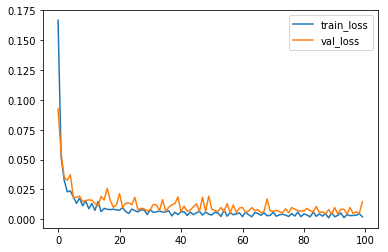

In [312]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [224]:
def rmse_train_test(model, X_train, X_test, y_train, y_test):
    """Reports RMSE of training and testing data given trained model"""
    
    y_pred1 = model.predict(X_train)
    y_pred2 = model.predict(X_test)
    rmse = [np.sqrt(mean_squared_error(y_train, y_pred1)), np.sqrt(mean_squared_error(y_test, y_pred2))]
    
    return rmse

In [225]:
def feature_select(X, Y):
    """Returns RMSE of test and training data for different regressors"""
    
    rmse_mat = np.zeros((9,3,2))
    for i in range(9):
        print(i)
        X, y = data_preprocess(X, Y[:,i])
        X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=110)

        reg = RandomForestRegressor(max_depth=15, random_state=0, n_estimators=100)
        reg.fit(X_train, y_train.reshape(len(y_train)))
        rmse = rmse_train_test(reg, X_train, X_test, y_train, y_test)
        rmse_mat[i,0] = rmse
        print("Random Forest", rmse)

        reg = DecisionTreeRegressor(max_depth=4, random_state=100)
#         reg.fit(X_train, y_train.reshape(len(y_train)))
#         rmse = rmse_train_test(reg, X_train, X_test, y_train, y_test)
#         rmse_mat[i,2] = rmse
#         print("Decision Tree", rmse)

        reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                                  n_estimators=1000, random_state=100)
        reg.fit(X_train, y_train.reshape(len(y_train)))
        rmse = rmse_train_test(reg, X_train, X_test, y_train, y_test)
        rmse_mat[i,1] = rmse
        print("AdaBoost", rmse)

        nn = nn_model(X_train, y_train)
        rmse = rmse_train_test(nn, X_train, X_test, y_train, y_test)
        rmse_mat[i,2] = rmse
        print("Neural Net", rmse)
        
    return rmse_mat

In [364]:
# rmse_matX1 = feature_select(X1, Y)
# rmse_matX2 = feature_select(np.column_stack((X1, X3, X4)), Y)
# rmse_matX3 = feature_select(Xall, Y)
rmse_matX4 = feature_select(np.column_stack((X1, X2)), Y)

0
Random Forest [0.01957939945636531, 0.0447458519792977]
AdaBoost [0.030692333559610915, 0.04746718823760596]
Neural Net [0.025309614086602664, 0.05307348839639633]
1
Random Forest [0.017413220625393914, 0.03849049595723584]
AdaBoost [0.02715538577239838, 0.03885358377009986]
Neural Net [0.02254726046163149, 0.0376934137141936]
2
Random Forest [0.018160090745388942, 0.0398651453305752]
AdaBoost [0.02555252390727808, 0.04156065001233573]
Neural Net [0.011764775167317955, 0.048105105344864896]
3
Random Forest [0.04927461673968996, 0.16236253061506642]
AdaBoost [0.08988892992786696, 0.16683555940812905]
Neural Net [0.06855930839073143, 0.16956468421317597]
4
Random Forest [0.036783081939047745, 0.09168260390941804]
AdaBoost [0.06784712545296419, 0.09907839784253075]
Neural Net [0.0500076909248188, 0.10517637039146682]
5
Random Forest [0.03431176874349209, 0.07393423485411321]
AdaBoost [0.05646947606930163, 0.079461383537465]
Neural Net [0.03364853577758462, 0.11662526684852953]
6
Random 

In [386]:
# np.save('./rmse_matX1_batch16.npy', rmse_matX1)
# np.save('./rmse_matX2_batch16.npy', rmse_matX2)
# np.save('./rmse_matX3_batch16.npy', rmse_matX3)
# np.save('./rmse_matX4.npy', rmse_matX4)

In [341]:
# rmse_matX1 = np.load('./rmse_matX1.npy')
# rmse_matX2 = np.load('./rmse_matX2.npy')
# rmse_matX3 = np.load('./rmse_matX3.npy')
# rmse_matX4 = np.load('./rmse_matX4.npy')

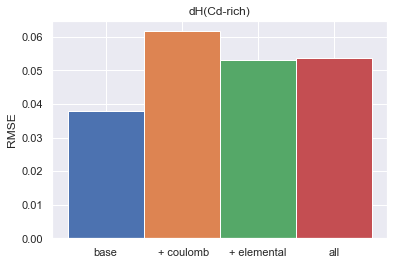

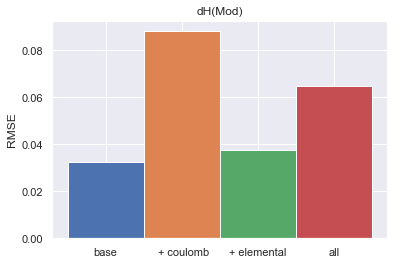

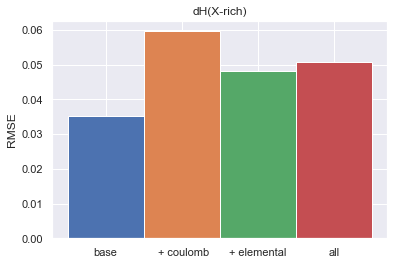

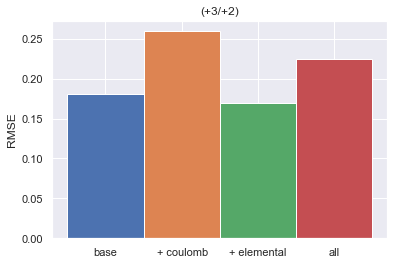

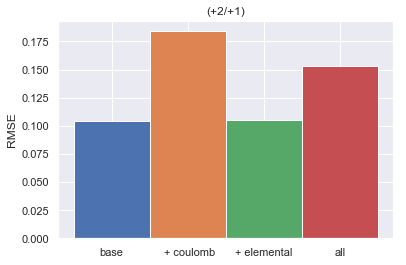

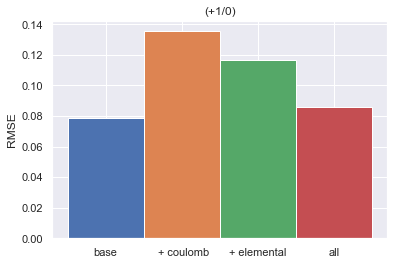

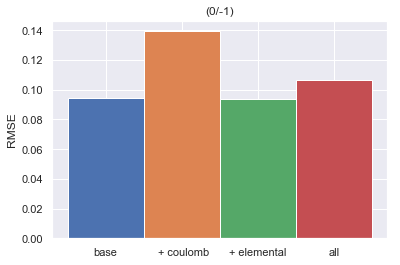

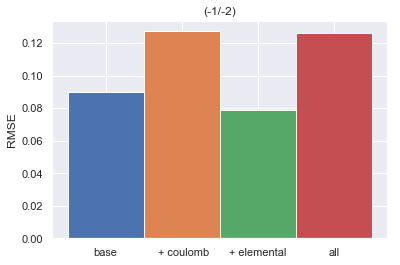

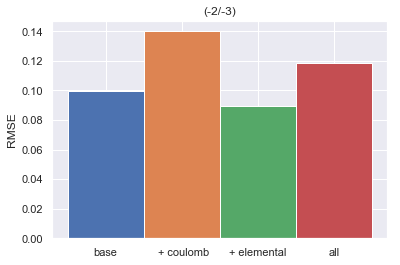

In [418]:
sns.set()
x_labels = ["base", " + coulomb", "+ elemental", "all"]
barWidth = 0.25
r1 = np.arange(4)/4

sns.set()

model_ind = 2  # NN

rmse_data = (rmse_matX1, rmse_matX2, rmse_matX4, rmse_matX3)
for yd in range(9):
    plt.figure()
    for p in range(4):
        plt.bar(r1[p], rmse_data[p][yd,model_ind,1], width=barWidth, edgecolor='white')
    plt.xticks(r1, x_labels)
    plt.title(Y_labels[yd])
    plt.ylabel("RMSE")
    


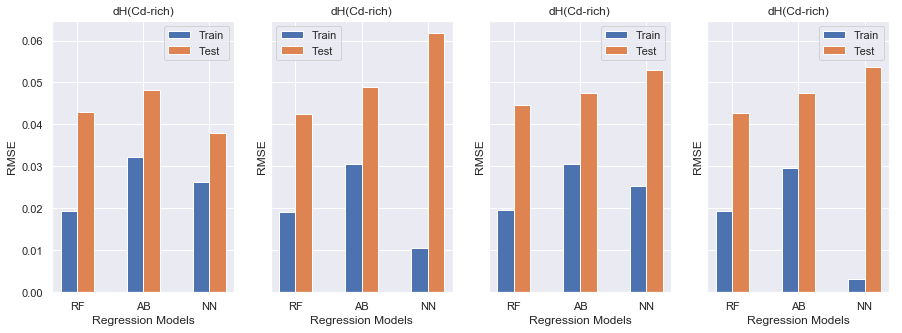

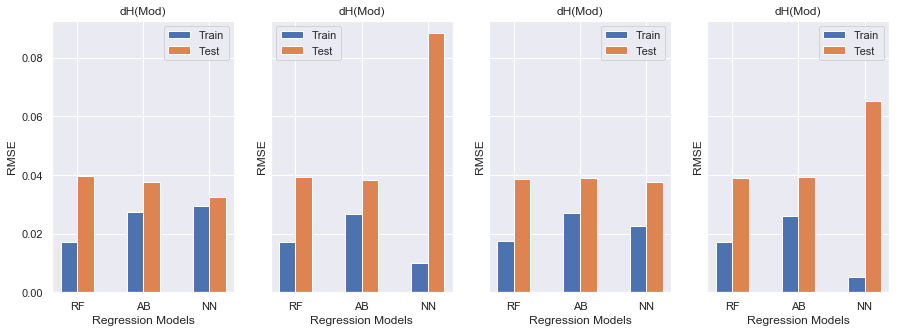

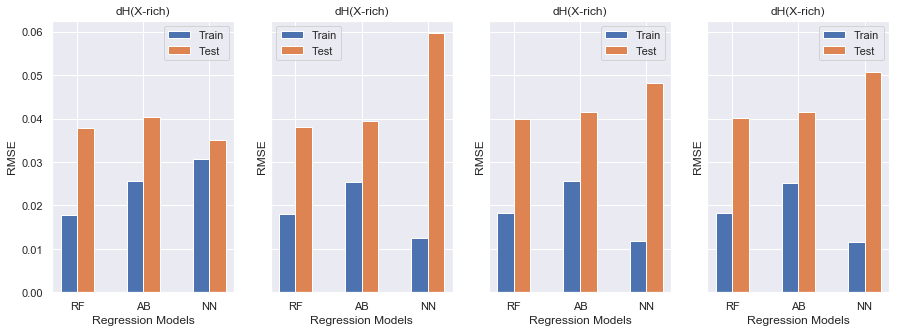

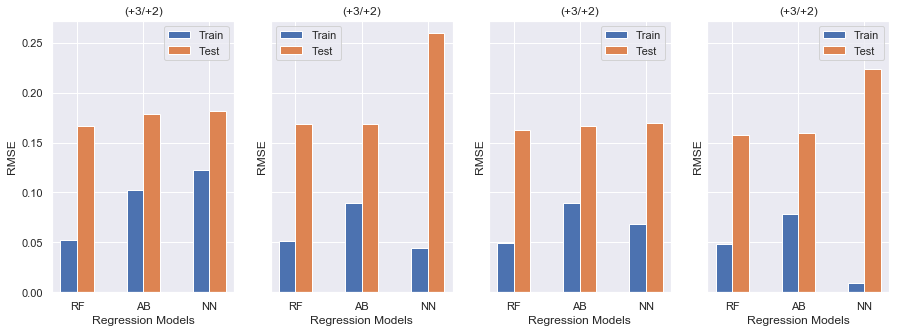

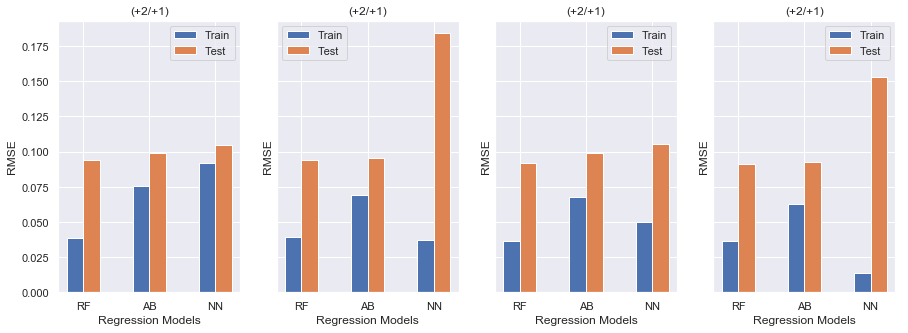

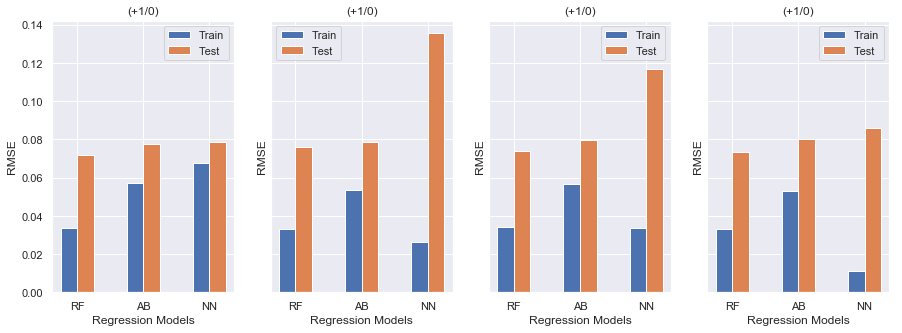

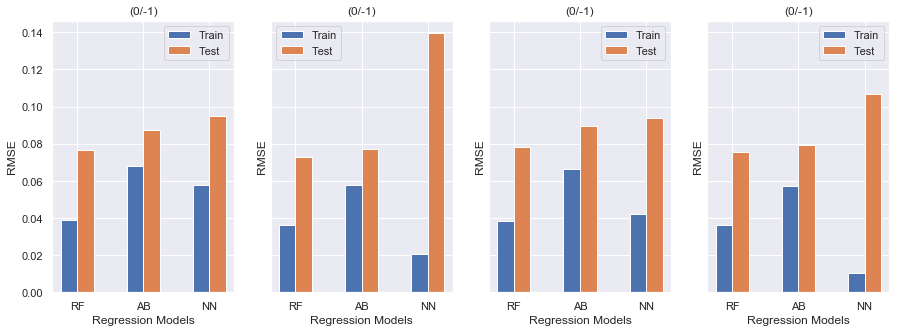

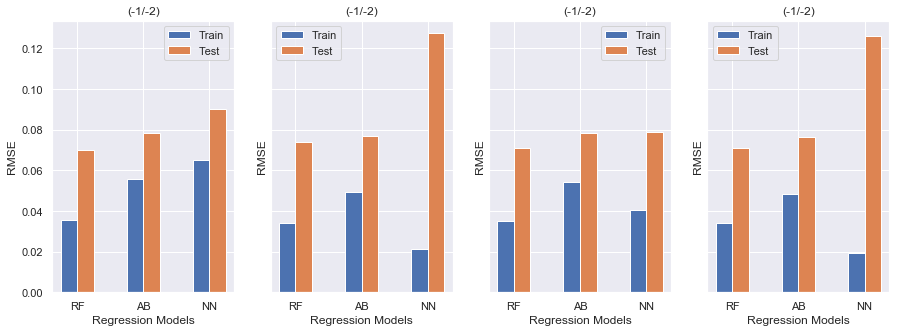

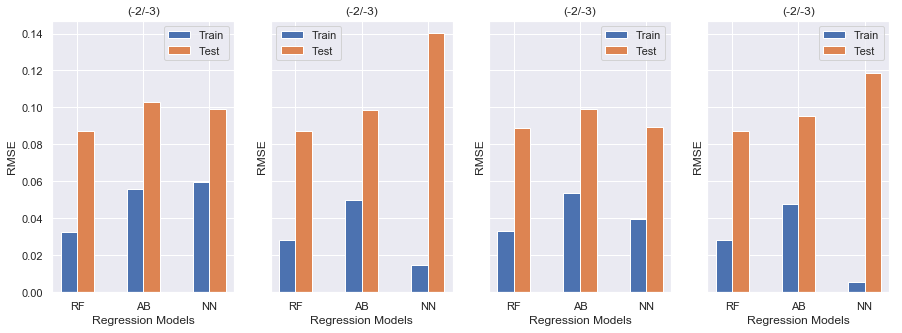

In [398]:
x_labels = ["RF", "AB", "NN"]
barWidth = 0.25
r1 = np.arange(3)
r2 = [x + barWidth for x in r1]

rmse_data = (rmse_matX1, rmse_matX2, rmse_matX4, rmse_matX3)
for yd in range(9):
    f, axes = plt.subplots(1, 4, sharey=True, figsize=(15,5))
    for p in range(4):
        axes[p].bar(r1, rmse_data[p][yd,:,0], width=barWidth, edgecolor='white', label='Train')
        axes[p].bar(r2, rmse_data[p][yd,:,1], width=barWidth, edgecolor='white', label='Test')
        axes[p].set_xlabel("Regression Models")
        axes[p].set_ylabel("RMSE")
        axes[p].set_title(Y_labels[yd])
        axes[p].set_xticks([r + barWidth/2 for r in r1])
        axes[p].set_xticklabels(x_labels)
        axes[p].legend()

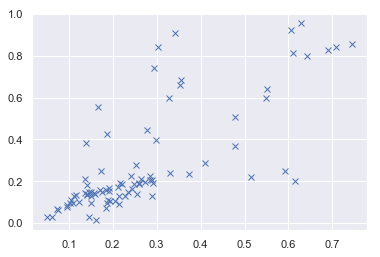

In [416]:
X = np.column_stack((X1,X3, X4))
y = Y[:,3]
X, y = data_preprocess(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                test_size=0.2, 
                                                random_state=110)
reg = RandomForestRegressor(max_depth=15, random_state=0, n_estimators=100)
reg.fit(X_train, y_train.reshape(len(y_train)))
ypred = reg.predict(X_test)
plt.plot(ypred, y_test, 'x')

### Neural net

In [244]:
X = Xall
y = Y[:,0]
X, y = data_preprocess(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        random_state=110)
nn = nn_model(X_train, y_train)
rmse = rmse_train_test(nn, X_train, X_test, y_train, y_test)
print("NN", rmse)

NN [0.1053730334155384, 0.11534556975220629]


Using TensorFlow backend.


In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=110)

In [117]:
def rfe_nn(X_train, y_train, X_test, y_test, best_loss, min_loss, x_ind_arr):
    """Recursive feature extraction for neural network"""
    
    loss = np.zeros(X_train.shape[1])     
    for x_ind in range(X_train.shape[1]):
        X_train_minus = np.column_stack((X_train[:, :x_ind], X_train[:, x_ind+1:]))
        model = nn_model(X_train_minus, y_train)

        X_test_minus =  np.column_stack((X_test[:, :x_ind], X_test[:, x_ind+1:]))
        loss[x_ind] = model.evaluate(X_train_minus, y_train)[0]

    toss_ind = np.argsort(loss)[0]
    x_ind_arr.append(toss_ind)
    X_train_new =  np.column_stack((X_train[:, :toss_ind], X_train[:, toss_ind+1:]))
    model = nn_model(X_train_new, y_train)

    X_test_new =  np.column_stack((X_test[:, :toss_ind], X_test[:, toss_ind+1:]))
    min_loss = model.evaluate(X_test_new, y_test)[0]
    
        
    if min_loss > best_loss:
        return min_loss, x_ind_arr, loss

    else:
        best_loss = min_loss
        print("recurse, " + str(best_loss))
        return rfe_nn(X_train_new, y_train, X_test_new, y_test, best_loss, min_loss, x_ind_arr)

In [118]:
seed = 7
np.random.seed(seed)

model = nn_model(X_train, y_train)
best_loss = model.evaluate(X_test, y_test)[0]
min_loss = 0
x_ind_arr = []

min_loss1, x_ind_arr1, loss_arr = rfe_nn(X_train, y_train, X_test, y_test, best_loss, min_loss, x_ind_arr)

85/85 [==============================] - 0s 317us/step


In [119]:
print(best_loss, min_loss, min_loss1)
print(x_ind_arr1)
print(loss_arr)

0.040110046241213296 0 0.04970425663187223
[44]
[0.03471938 0.03199729 0.03216348 0.03969894 0.02890659 0.0351
 0.02969489 0.0371175  0.04486885 0.02743762 0.03164344 0.02835189
 0.02679586 0.03153474 0.03279598 0.02998269 0.03059182 0.02926903
 0.02582373 0.03110725 0.02848902 0.02625813 0.03737889 0.02639468
 0.04028205 0.03826772 0.02698388 0.02662224 0.0327618  0.03122819
 0.03870056 0.02991258 0.02486411 0.0295211  0.04261107 0.02783936
 0.04131449 0.03098336 0.03893964 0.04277752 0.03048978 0.02858646
 0.03214719 0.04106948 0.02482619]


In [111]:
np.sort(loss_arr)

array([0.00528674, 0.00547643, 0.00565898, 0.00576849, 0.00670359,
       0.00674951, 0.00698028, 0.00713151, 0.0072755 , 0.0083822 ,
       0.0084844 , 0.00871504, 0.00875406, 0.00898172, 0.0089985 ,
       0.0095219 , 0.00954282, 0.01000946, 0.01053986, 0.01070185,
       0.01105103, 0.01122408, 0.01151845, 0.01200035, 0.01226472,
       0.01257326, 0.01283661, 0.01339874, 0.01381406, 0.01415869,
       0.01525002, 0.01562337, 0.0157929 , 0.01640798, 0.01675115,
       0.01712312, 0.01737598, 0.01750225, 0.01777107, 0.01891292,
       0.02238469, 0.02250542, 0.02749651, 0.03134786])

In [52]:
loss = np.zeros(X_train.shape[1])

for x_ind in range(X_train.shape[1]):
    X_train_minus = np.column_stack((X_train[:, :x_ind], X_train[:, x_ind+1:]))
    model = nn_model(X_train_minus, y_train)
    
    X_test_minus =  np.column_stack((X_test[:, :x_ind], X_test[:, x_ind+1:]))
    loss[x_ind] = model.evaluate(X_test_minus, y_test)[0]
    

85/85 [==============================] - 0s 70us/step


In [53]:
toss_ind = np.argsort(loss)[-1]
X_train_new =  np.column_stack((X_train[:, :toss_ind], X_train[:, toss_ind+1:]))
model = nn_model(X_train_new, y_train)

X_test_new =  np.column_stack((X_test[:, :toss_ind], X_test[:, toss_ind+1:]))
model.evaluate(X_test_new, y_test)[0]

85/85 [==============================] - 0s 82us/step


0.18170601515208973

In [69]:
model = nn_model(X_train, y_train)
best_loss = model.evaluate(X_test, y_test)[0]
best_loss

85/85 [==============================] - 0s 94us/step


0.14413854234358844

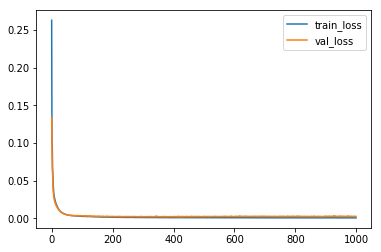

In [241]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()